In [1]:
import math
import torch
from contextual_gaussian import ContextualGaussianDataset, contextual_gaussian
from dvi_process import DIS
from matplotlib import pyplot as plt
from score_function import ScoreFunction
from torch.distributions import Normal
from torch.utils.data import DataLoader
from train import train
import seaborn as sns

In [2]:
import torch_directml

device = torch_directml.device()

In [3]:
dataset = ContextualGaussianDataset(size=4096)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)

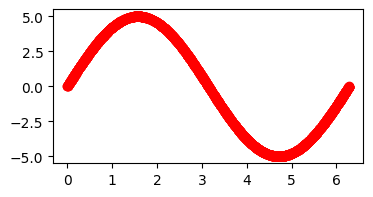

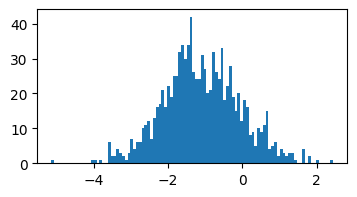

In [4]:
batch = next(iter(dataloader))

contextual_gaussians = [contextual_gaussian(x) for x in batch]
samples = contextual_gaussians[0].sample((1000,))

plt.figure(figsize=(4, 2))
plt.scatter(batch, [g.mean for g in contextual_gaussians], color="red")
plt.show()

plt.figure(figsize=(4, 2))
plt.hist(samples, bins=100)
plt.show()

In [5]:
c_dim = 1
z_dim = 1
h_dim = 32
num_layers = 3
non_linearity = "ReLU"
num_steps = 16
learning_rate = 3e-4

In [6]:
score_function = ScoreFunction(c_dim=c_dim, h_dim=h_dim, z_dim=z_dim, num_layers=num_layers, non_linearity=non_linearity, num_steps=num_steps)
dis = DIS(z_dim=z_dim, num_steps=num_steps, score_function=score_function).to(device)

optimizer = torch.optim.Adam(dis.parameters(), lr=learning_rate)

In [7]:
import wandb

wandb_logging = True
if wandb_logging:
    wandb.init(project="dvi")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


In [49]:
losses = train(dis, device, dataloader, optimizer, 1000, wandb_logging=wandb_logging)

100%|██████████| 2/2 [00:00<00:00,  2.23it/s, epoch=999, loss=0.598]


In [100]:
torch.save(dis.state_dict(), "model.pth")

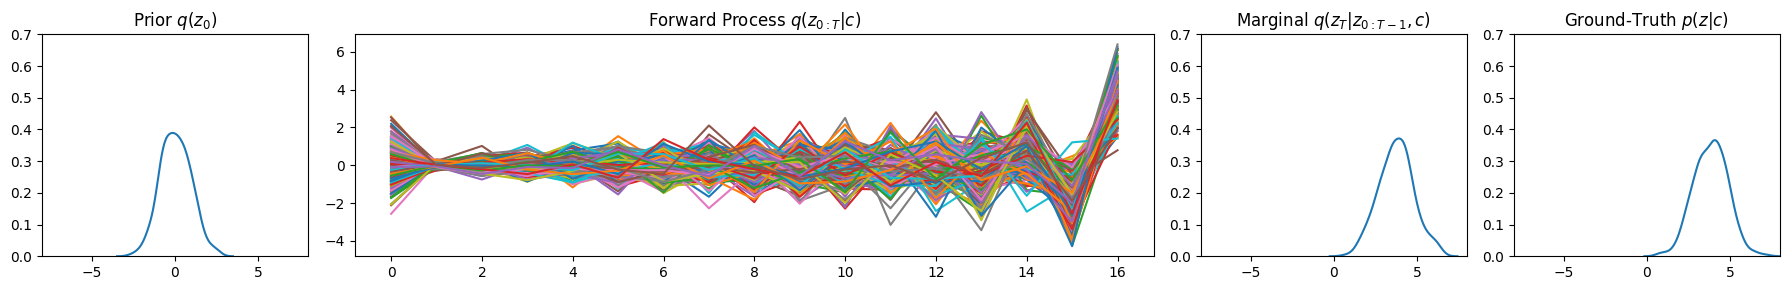

In [110]:
import numpy as np

num_samples = 256

# context = torch.ones((z_dim), device=device).unsqueeze(0).repeat(num_samples, 1)  * 3 * math.pi/2
# context = torch.zeros((z_dim), device=device).unsqueeze(0).repeat(num_samples, 1)
context = torch.ones((z_dim), device=device).unsqueeze(0).repeat(num_samples, 1) * np.random.rand() * 2 * math.pi

p_z_0 = Normal(
    torch.zeros((num_samples, z_dim), device=device),
    torch.ones((num_samples, z_dim), device=device),
)

p_z_T = contextual_gaussian(context)

dis.eval()
with torch.no_grad():
    p_z_forward, z_forward = dis.forward_chain(p_z_0, context)

    z_0_samples = z_forward[0].squeeze(1).tolist()
    z_T_samples = z_forward[-1].squeeze(1).tolist()

    z_trajectories = [[z[i].cpu().numpy() for z in z_forward] for i in range(num_samples)]

    z_samples = contextual_gaussian(context.cpu()).sample().squeeze(1).tolist()

fig, ax = plt.subplots(1, 4, figsize=(18, 3), gridspec_kw={'width_ratios': [1, 3, 1, 1]})

sns.kdeplot(z_0_samples, ax=ax[0])
ax[0].set_title("Prior $q(z_0)$")
ax[0].set_ylabel(None)
ax[0].set_xlim(-8, 8)
ax[0].set_ylim(0, 0.7)

for i in range(num_samples):
    ax[1].plot(z_trajectories[i])
ax[1].set_title("Forward Process $q(z_{0:T}|c)$")

sns.kdeplot(z_T_samples, ax=ax[2])
ax[2].set_title("Marginal $q(z_T|z_{0:T-1},c)$")
ax[2].set_ylabel(None)
ax[2].set_xlim(-8, 8)
ax[2].set_ylim(0, 0.7)

sns.kdeplot(z_samples, ax=ax[3])
ax[3].set_title("Ground-Truth $p(z|c)$")
ax[3].set_ylabel(None)
ax[3].set_xlim(-8, 8)
ax[3].set_ylim(0, 0.7)

plt.tight_layout()
plt.show()